In [1]:
import numpy as np
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import pickle
import numpy as np
from matplotlib.font_manager import FontProperties
import io
from PIL import Image
from flask import Flask, render_template
from flask_socketio import SocketIO

app = Flask(__name__)
socketio = SocketIO(app)

In [20]:

plt.style.use(['science','grid'])
plt.style.use(['science','no-latex'])
plt.rcParams['axes.unicode_minus'] = False
# 修改图中的默认字体
# plt.rc('font',family='Times New Roman')
plt.rcParams['font.sans-serif']=['SimSun']
font_set = FontProperties(fname=r'C:\Windows\Fonts\simsun.ttc')

score_result = np.array([[0.1, 0.2, 0.3], [0.2, 0.3, 0.4], [3, 5, 6], [3, 5, 6], [0, 0, 0],[0.03, 0.01, 0.01],[0.05, 0.05, 0.05], [0.16, 0.09, 0.09],
                         [0.23, 0.05, 0.05],[0.1, 0.05, 0.05],[0.2, 0.05, 0.05],[0.3, 0.05, 0.05],[0.26, 0.05, 0.05],[0.24, 0.05, 0.05],[0.22, 0.05, 0.05],[0.2, 0.05, 0.05],
                         [0.05, 0.05, 0.05],[0.8, 5, 6],[0.3, 0.05, 0.05],[1.0, 0.05, 0.05],[1.46, 0.05, 0.05],[0.47, 0.05, 0.05],[0.05, 0.05, 0.05],[0.05, 0.05, 0.05],
                         [0.05, 0.05, 0.05],[0.05, 0.05, 0.05],[0.1, 0.05, 0.05],[0.12, 0.05, 0.05],[0.05, 0.05, 0.05],[0.2, 0.05, 0.05],[0.24, 0.05, 0.05],[0.35, 0.05, 0.05],
                         [0.2, 0.05, 0.05],[0.2, 0.05, 0.05],[0.2, 0.05, 0.05],[0.1, 0.05, 0.05],[0.15, 0.05, 0.05],[0.11, 0.05, 0.05],[0.22, 0.05, 0.05],[0.14, 0.05, 0.05],
                         [0.05, 0.05, 0.05],[0.1, 0.05, 0.05],[0.15, 0.05, 0.05],[0.25, 0.05, 0.05],[0.11, 0.05, 0.05],[0.38, 0.05, 0.05],[0.30, 0.05, 0.05],[0.26, 0.05, 0.05],
                         [0.36, 0.05, 0.05],[0.234, 0.05, 0.05],[3, 5, 6],[0.05, 0.05, 0.05],[0.05, 0.05, 0.05],[0.05, 0.05, 0.05],[0.05, 0.05, 0.05],[0.05, 0.05, 0.05],

                         [0.2, 0.05, 0.05],[0.05, 0.05, 0.05],[0.11, 0.05, 0.05],[0.12, 0.05, 0.05],[0.13, 0.05, 0.05],[0.11, 0.05, 0.05],[0.11, 0.05, 0.05],[0.15, 0.05, 0.05],])
#                              N               Y             Y          Y          Y        Y            Y
max_score = [0.1, 0.2, 0.3]

x_label = [i for i in range(len(score_result))]
last_result = np.array([1.0] * len(max_score))
Delta = [15] * len(max_score)

# result is anomaly result, last is last time_score
def gp_func(result, last_time_score):
    # print(f'result: {result}')
    b = 1
    c = 0.3
    x = (1 / (1 + np.exp(-b * (result - last_time_score))))
    # y = 1 - np.exp(-c * (1 - (result * (result - last_time_score) - 0.1) / 0.9))
    # 正常result为 1，result - last_time_score 差距最大， y随着 last_time_scode 增大，差距减小，y 会增大，输出会增大，c控制增长速率
    #
    w = (1 - (result * (result - last_time_score)))
    z = 1 + np.exp(-50 * (last_time_score-0.2))
    y = 1 - np.exp(-c * w * z)
    # print(f'w : {w} z : {z}')
    # print(f'x : {x} y : {y}')
    res = ((x * y))
    # print(f'res : {res}')
    # res = res * last_time_score
    # print(f'Finall res {res}')
    # res = np.fmax(res, 0.1)
    # res = np.fmin(res, 1)
    return res

time_score = np.array([1] * len(max_score))
time_result = np.array([1] * len(max_score))
y_list = [[],[],[]]
c = np.zeros_like(time_score)

for index, score in enumerate(score_result):
    # print('____________________________________')
    time_score = gp_func(last_result, time_result)
    time_result = time_result * (time_score + last_result)
    # print(f'time_result raw {time_result}')
    time_result = np.fmin(time_result, 1)
    time_result = np.fmax(time_result, 0.06)
    # print(f'time_result {time_result}')
    comp_array = max_score * np.multiply(Delta, time_result)
    arr = np.greater_equal(comp_array, score)
    # print(arr)
    if np.all(arr):
        last_result[:] = 1
    else:
        last_result[:] = 0
    y_list[0].append(comp_array[0])
    y_list[1].append(comp_array[1])
    y_list[2].append(comp_array[2])


# ax = plt.subplot(131)
# 评估分数

plt.xlabel("序列索引", fontproperties=font_set)
plt.ylabel("异常分数", fontproperties=font_set)
plt.plot(x_label, y_list[0], 'r', label='阈值')
plt.plot(x_label, score_result[:,0], 'bo', label='异常分数')
# plt.grid(color='k', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.legend(prop=font_set)
# 异常点 红：异常， 蓝 ： 正常
# plt.plot(index, m)

# plt.show()
png1 = io.BytesIO()
plt.savefig(png1, format='png', dpi=300)
png2 = Image.open(png1)
# Save as TIFF
png2.save('./threahold.tif')
png1.close()
plt.clf()

<Figure size 2100x1575 with 0 Axes>

In [50]:

# with open(os.path.join(save_file_path, 'test_sc_time_interval_persec_' + str(TIME_PERIOD)),'r') as f:
#     test_sc_time_interval_persec = json.load(f)

path K:/hids/LID-DS-master/tools/out\CWE-89-SQL-injection not exist


In [51]:
with open('L:\\hids\\dataSet\\GP_DATA_DIR\\CWE-89-SQL-injection\\test\\normal_and_attack\\most_williams_5320\\df_all.pkl', 'rb') as f:
    df_all = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'L:\\hids\\dataSet\\GP_DATA_DIR\\CWE-89-SQL-injection\\test\\normal_and_attack\\most_williams_5320\\df_all.pkl'

In [4]:
df = pd.read_csv('K:\\hids\\dataSet\\CVE-2014-0160\\test\\normal_and_attack\\dry_shannon_1464.sc',delim_whitespace = True, names = ['time','UserID', 'PID', 'ProcessName', 'TID', 'syscall', 'DIR', 'RET', 'ARGS'])

In [10]:
df['ARGS']

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
      ... 
115    NaN
116    NaN
117    NaN
118    NaN
119    NaN
Name: ARGS, Length: 120, dtype: object

In [106]:
normal_df = pd.DataFrame(test_sc_time_interval_persec['NORMAL'])
exploit_df = pd.DataFrame(test_sc_time_interval_persec['ATTACK'])

In [107]:
normal_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
count,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000,1202.000000
mean,3429.757903,2.002496,1.526622,1.224626,1.229617,1.302829,1.269551,1.215474,0.801997,0.621464,0.468386,0.413478,0.364393,0.325291,0.298669,0.273710,0.242097,0.200499,0.216306,0.211314,9.869384
std,3642.498253,2.113159,2.108159,1.688318,1.408499,1.300666,1.291961,1.259499,1.002443,0.829698,0.756487,0.658956,0.654451,0.589819,0.565286,0.555758,0.506864,0.481705,0.492881,0.465573,2.111878
min,29.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
25%,1295.750000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000
50%,3045.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
75%,4701.500000,3.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000
max,47222.000000,19.000000,33.000000,26.000000,15.000000,12.000000,13.000000,14.000000,8.000000,6.000000,6.000000,4.000000,4.000000,4.000000,4.000000,3.000000,3.000000,4.000000,3.000000,3.000000,18.000000


In [108]:
exploit_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
count,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000,378.000000
mean,6348.706349,2.354497,3.325397,2.703704,1.809524,1.748677,1.595238,1.571429,1.333333,1.076720,0.732804,0.600529,0.423280,0.365079,0.357143,0.333333,0.325397,0.306878,0.224868,0.240741,10.222222
std,9952.007498,2.959720,5.424910,4.619993,3.216455,2.129199,2.207457,1.837259,1.748057,1.470105,1.055506,0.996918,0.767847,0.666793,0.657109,0.559462,0.561771,0.531257,0.482825,0.522929,2.118088
min,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,1954.250000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
50%,2916.000000,1.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,10.000000
75%,4644.750000,3.000000,3.000000,3.000000,2.000000,3.000000,2.000000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,11.000000
max,57680.000000,18.000000,32.000000,38.000000,22.000000,14.000000,15.000000,12.000000,9.000000,9.000000,6.000000,6.000000,4.000000,4.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,17.000000


协方差

In [109]:
normal_df.cov()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.326779e+07,4774.136325,5420.022687,4115.341687,2616.711756,1981.194108,2352.835503,1908.157122,1679.119385,1073.834177,888.161782,614.675539,627.244828,505.802381,389.307171,429.938093,234.762240,329.854576,283.437923,281.836380,2852.711899
1,4.774136e+03,4.465439,1.614838,1.079372,0.924489,0.592083,0.690417,0.517364,0.450120,0.349821,0.333551,0.215453,0.276359,0.164883,0.166614,0.200815,0.120961,0.204328,0.121025,0.140188,1.220143
2,5.420023e+03,1.614838,4.444336,2.003174,1.048836,0.767951,0.782160,0.882269,0.658898,0.357713,0.296013,0.200057,0.150158,0.166603,0.120685,0.057237,0.068903,0.084999,0.082496,0.098450,0.071340
3,4.115342e+03,1.079372,2.003174,2.850417,0.894258,0.504776,0.658802,0.576871,0.554922,0.325732,0.183627,0.123531,0.137064,0.140859,0.041099,0.033387,0.023842,0.042352,0.074602,0.030762,0.188398
4,2.616712e+03,0.924489,1.048836,0.894258,1.983868,0.359217,0.365199,0.308517,0.342755,0.163594,0.192111,0.072340,0.134411,0.106761,0.054594,0.089472,0.030126,0.014706,0.055204,0.038033,0.293963
5,1.981194e+03,0.592083,0.767951,0.504776,0.359217,1.691732,0.178088,0.094561,0.200727,0.108898,0.087017,0.085341,0.076903,0.053784,0.051861,0.034446,0.022379,0.043312,0.050179,0.040035,0.301036
6,2.352836e+03,0.690417,0.782160,0.658802,0.365199,0.178088,1.669164,0.216641,0.329853,0.140421,0.130094,0.082459,0.076550,0.040471,0.054314,0.013587,0.007128,0.062480,0.040730,0.043742,0.499017
7,1.908157e+03,0.517364,0.882269,0.576871,0.308517,0.094561,0.216641,1.586338,0.216722,0.099118,0.174595,0.070699,0.070460,0.058909,0.019688,0.058376,0.003578,-0.001606,0.042445,0.007718,0.043155
8,1.679119e+03,0.450120,0.658898,0.554922,0.342755,0.200727,0.329853,0.216722,1.004892,0.099008,0.101146,0.085269,0.060554,0.076119,0.017555,0.031759,0.040482,0.045561,0.041200,0.031051,0.253883
9,1.073834e+03,0.349821,0.357713,0.325732,0.163594,0.108898,0.140421,0.099118,0.099008,0.688398,0.040063,0.034248,0.069774,0.045801,0.029887,0.045411,0.030103,0.030997,0.033655,0.022605,0.222789


In [110]:
exploit_df.cov()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,9.904245e+07,22623.154772,50138.835860,41642.912762,28082.134900,15990.109027,17558.848996,12935.595301,13134.618037,9280.027894,5109.576502,6222.068060,3525.580860,2112.635342,1567.731148,703.713528,387.501642,70.103617,-44.464296,233.434276,-7794.499558
1,2.262315e+04,8.759940,11.048798,8.659692,5.622079,3.375802,3.740685,2.579386,2.597701,1.683606,1.214335,1.425807,0.738144,0.612943,0.568018,0.308576,0.194687,0.060685,0.058005,0.174379,-1.118774
2,5.013884e+04,11.048798,29.429645,21.489243,13.966654,7.928150,8.951686,6.598712,6.543767,4.478948,2.392215,2.942002,1.811503,0.960465,0.734937,0.302387,0.082165,0.048419,-0.062755,-0.006926,-4.687887
3,4.164291e+04,8.659692,21.489243,21.344336,11.940760,6.492976,7.362511,5.732095,5.372237,3.571864,2.077120,2.313685,1.603203,0.941350,0.511936,0.213086,0.226643,0.000982,-0.055212,0.018469,-4.554671
4,2.808213e+04,5.622079,13.966654,11.940760,10.345585,4.479853,4.989011,3.536188,3.575597,2.733485,1.261968,1.631931,0.980043,0.494127,0.359985,0.185676,0.038272,0.029430,0.050903,0.080460,-2.872679
5,1.599011e+04,3.375802,7.928150,6.492976,4.479853,4.533486,2.667235,1.809776,1.980548,1.536574,0.914102,0.986871,0.533718,0.235232,0.254452,0.158267,-0.034714,-0.031423,-0.054742,0.007614,-1.479811
6,1.755885e+04,3.740685,8.951686,7.362511,4.989011,2.667235,4.872869,2.168246,2.469496,1.712833,0.936655,1.063345,0.508652,0.267526,0.182077,0.066313,0.012694,-0.023999,-0.022799,-0.064103,-1.734748
7,1.293560e+04,2.579386,6.598712,5.732095,3.536188,1.809776,2.168246,3.375521,1.838196,1.186813,0.611974,0.724896,0.471012,0.249716,0.161425,0.029178,0.004547,-0.029936,0.017052,0.002653,-1.225464
8,1.313462e+04,2.597701,6.543767,5.372237,3.575597,1.980548,2.469496,1.838196,3.055703,1.284704,0.760389,0.775420,0.428824,0.249337,0.190981,0.034483,0.021220,-0.078691,-0.059240,-0.000884,-1.233422
9,9.280028e+03,1.683606,4.478948,3.571864,2.733485,1.536574,1.712833,1.186813,1.284704,2.161207,0.516575,0.569190,0.285742,0.141678,0.020273,-0.017683,0.025367,-0.039521,-0.059738,-0.021171,-0.889773


相关系数

In [111]:
normal_df.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.000000,0.620245,0.705827,0.669194,0.510035,0.418179,0.499969,0.415927,0.459857,0.355319,0.322323,0.256089,0.263124,0.235431,0.189071,0.212384,0.127156,0.187993,0.157876,0.166192,0.370843
1,0.620245,1.000000,0.362488,0.302542,0.310608,0.215419,0.252889,0.194386,0.212489,0.199524,0.208655,0.154727,0.199831,0.132289,0.139480,0.170993,0.112933,0.200732,0.116199,0.142493,0.273407
2,0.705827,0.362488,1.000000,0.562809,0.353222,0.280069,0.287172,0.332276,0.311785,0.204508,0.185612,0.144011,0.108835,0.133987,0.101270,0.048852,0.064483,0.083701,0.079394,0.100305,0.016024
3,0.669194,0.302542,0.562809,1.000000,0.376056,0.229868,0.302031,0.271285,0.327882,0.232534,0.143774,0.111037,0.124049,0.141453,0.043063,0.035583,0.027861,0.052077,0.089651,0.039136,0.052839
4,0.510035,0.310608,0.353222,0.376056,1.000000,0.196080,0.200689,0.173910,0.242755,0.139988,0.180300,0.077941,0.145815,0.128510,0.068568,0.114300,0.042198,0.021675,0.079519,0.057998,0.098825
5,0.418179,0.215419,0.280069,0.229868,0.196080,1.000000,0.105979,0.057723,0.153950,0.100910,0.088438,0.099571,0.090345,0.070108,0.070535,0.047652,0.033945,0.069130,0.078273,0.066112,0.109593
6,0.499969,0.252889,0.287172,0.302031,0.200689,0.105979,1.000000,0.133136,0.254689,0.130997,0.133109,0.096857,0.090536,0.053110,0.074370,0.018923,0.010885,0.100394,0.063962,0.072721,0.182893
7,0.415927,0.194386,0.332276,0.271285,0.173910,0.057723,0.133136,1.000000,0.171650,0.094849,0.183245,0.085184,0.085480,0.079298,0.027652,0.083396,0.005604,-0.002648,0.068374,0.013162,0.016224
8,0.459857,0.212489,0.311785,0.327882,0.242755,0.153950,0.254689,0.171650,1.000000,0.119039,0.133379,0.129084,0.092301,0.128741,0.030979,0.057007,0.079673,0.094352,0.083386,0.066533,0.119924
9,0.355319,0.199524,0.204508,0.232534,0.139988,0.100910,0.130997,0.094849,0.119039,1.000000,0.063830,0.062642,0.128498,0.093592,0.063723,0.098481,0.071582,0.077556,0.082297,0.058518,0.127147


In [112]:
exploit_df.corr()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,1.000000,0.768054,0.928691,0.905710,0.877287,0.754614,0.799269,0.707466,0.755007,0.634294,0.486422,0.627140,0.461366,0.318363,0.239731,0.126391,0.069311,0.013259,-0.009254,0.044855,-0.369772
1,0.768054,1.000000,0.688132,0.633302,0.590567,0.535686,0.572543,0.474346,0.502092,0.386938,0.388711,0.483226,0.324800,0.310583,0.292061,0.186355,0.117092,0.038595,0.040590,0.112668,-0.178463
2,0.928691,0.688132,1.000000,0.857407,0.800428,0.686378,0.747515,0.662058,0.690049,0.561611,0.417779,0.543990,0.434882,0.265520,0.206168,0.099632,0.026961,0.016800,-0.023959,-0.002441,-0.407982
3,0.905710,0.633302,0.857407,1.000000,0.803550,0.660064,0.721925,0.675308,0.665209,0.525903,0.425951,0.502347,0.451931,0.305576,0.168631,0.082441,0.087326,0.000400,-0.024751,0.007645,-0.465449
4,0.877287,0.590567,0.800428,0.803550,1.000000,0.654139,0.702659,0.598394,0.635939,0.578084,0.371715,0.508938,0.396819,0.230393,0.170321,0.103183,0.021181,0.017223,0.032778,0.047836,-0.421663
5,0.754614,0.535686,0.686378,0.660064,0.654139,1.000000,0.567483,0.462635,0.532125,0.490896,0.406741,0.464927,0.326453,0.165687,0.181867,0.132863,-0.029022,-0.027780,-0.053249,0.006838,-0.328130
6,0.799269,0.572543,0.747515,0.721925,0.702659,0.567483,1.000000,0.534621,0.639971,0.527806,0.402001,0.483195,0.300092,0.181753,0.125523,0.053695,0.010237,-0.020464,-0.021391,-0.055532,-0.371022
7,0.707466,0.474346,0.662058,0.675308,0.598394,0.462635,0.534621,1.000000,0.572356,0.439404,0.315575,0.395773,0.333877,0.203838,0.133710,0.028386,0.004406,-0.030670,0.019223,0.002761,-0.314910
8,0.755007,0.502092,0.690049,0.665209,0.635939,0.532125,0.639971,0.572356,1.000000,0.499919,0.412116,0.444961,0.319484,0.213914,0.166264,0.035259,0.021609,-0.084736,-0.070189,-0.000967,-0.333129
9,0.634294,0.386938,0.561611,0.525903,0.578084,0.490896,0.527806,0.439404,0.499919,1.000000,0.332908,0.388373,0.253135,0.144532,0.020986,-0.021501,0.030716,-0.050603,-0.084161,-0.027539,-0.285751


统计数量

In [113]:
df['TID'].value_counts()

3861861    18490
3863662    12599
3863969    11504
3862926    10962
3862925    10210
3863814     9234
3863204     8544
3863663     7738
3862921     6662
3862770     6502
3863815     6214
3863970     6080
3864128     6068
3862923     5792
3863713     5772
3862924     5618
3863968     4923
3863971     4823
3864131     4516
3866717     2404
3864134     2398
3864132     2208
3864127     2166
3864133     1834
3867158     1580
3864129      265
3864130      265
3862914      236
3862057      142
3862052      134
3862058      134
3862060      130
3862051      130
3862056      130
3862054      130
3862055      130
3862059      130
3862053      130
3862308      128
3862309      128
3862354       98
3862310       72
3862355       66
3862357       66
3862313       26
3862286       24
3862312       24
3862311       24
3861918        4
Name: TID, dtype: int64

In [114]:
df

,time,UserID,PID,ProcessName,TID,syscall,DIR,ARGS
0,1631083490806378308,101,3861861,mysqld,3862354,select,<,res=0
1,1631083490806386943,101,3861861,mysqld,3862354,select,>,NaN
2,1631083490806627721,101,3861861,mysqld,3862355,select,<,res=0
3,1631083490806631058,101,3861861,mysqld,3862355,select,>,NaN
4,1631083490812467214,101,3861861,mysqld,3862357,select,<,res=0
...,...,...,...,...,...,...,...,...
167582,1631083523023764457,101,3861861,mysqld,3862054,io_getevents,>,NaN
167583,1631083523023782486,101,3861861,mysqld,3862059,io_getevents,<,NaN
167584,1631083523023789191,101,3861861,mysqld,3862059,io_getevents,>,NaN
167585,1631083523023805276,101,3861861,mysqld,3862053,io_getevents,<,NaN


In [115]:
bin_res = pd.cut(x=df['time'], bins=32)

In [116]:

# df.pivot_table(index=bin_res, columns='PID', values='TID', aggfunc='sum')

# df.groupby(bin_res).count()
pd.Timestamp(1631083523023808878)

Timestamp('2021-09-08 06:45:23.023808878')

In [31]:
df.time = pd.to_datetime(df['time'])

In [32]:
df

,time,UserID,PID,ProcessName,TID,syscall,DIR,ARGS
0,2021-09-08 06:44:50.806378308,101,3861861,mysqld,3862354,select,<,res=0
1,2021-09-08 06:44:50.806386943,101,3861861,mysqld,3862354,select,>,NaN
2,2021-09-08 06:44:50.806627721,101,3861861,mysqld,3862355,select,<,res=0
3,2021-09-08 06:44:50.806631058,101,3861861,mysqld,3862355,select,>,NaN
4,2021-09-08 06:44:50.812467214,101,3861861,mysqld,3862357,select,<,res=0
...,...,...,...,...,...,...,...,...
167582,2021-09-08 06:45:23.023764457,101,3861861,mysqld,3862054,io_getevents,>,NaN
167583,2021-09-08 06:45:23.023782486,101,3861861,mysqld,3862059,io_getevents,<,NaN
167584,2021-09-08 06:45:23.023789191,101,3861861,mysqld,3862059,io_getevents,>,NaN
167585,2021-09-08 06:45:23.023805276,101,3861861,mysqld,3862053,io_getevents,<,NaN


In [2]:
import zipfile

# 解压缩文件
def unzip_files(zip_file, extract_dir):
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall(extract_dir)

# 重命名文件
def rename_files(directory, file_num):
    files = os.listdir(directory)
    for file_name in files:
        if file_name.endswith('.pcap') or file_name.endswith('.res'):
            os.remove(os.path.join(directory, file_name))
        else:
            new_file_name = f'{file_num}{os.path.splitext(file_name)[1]}'
            os.rename(os.path.join(directory, file_name), os.path.join(directory, new_file_name))


In [2]:
paths = os.walk(r'L:/hids/dataSet/ZipSlip')
file_num = 1
for path, dir_lst, file_lst in paths:
    for file_name in file_lst:
        file_path = os.path.join(path, file_name)
        new_dir = os.path.join(path, f'{file_num}')
        unzip_files(file_path, new_dir)
        # 重命名文件
        rename_files(new_dir, file_num)

        # 压缩新的文件
        with zipfile.ZipFile(f'{file_num}.zip', 'w', zipfile.ZIP_DEFLATED) as zip_ref:
            files = os.listdir(new_dir)
            for dir_file in files:
                new_dir_file_path = os.path.join(path, dir_file)
                zip_ref.write(new_dir_file_path, os.path.relpath(new_dir_file_path, path))

        file_num += 1


In [61]:
df

,time,UserID,PID,ProcessName,TID,syscall,DIR,ARGS
0,1631043631854280356,33,1672460,apache2,1672460,poll,<,res=1
1,1631043631854282585,33,1672460,apache2,1672460,read,>,fd=10(<4t>172.20.0.3:56904->172.20.0.11:80)
2,1631043631854284551,33,1672460,apache2,1672460,read,<,res=579
3,1631043631854325118,33,1672460,apache2,1672460,stat,>,NaN
4,1631043631854345039,33,1672460,apache2,1672460,stat,<,res=0
...,...,...,...,...,...,...,...,...
158483,1631043676188163475,101,1672006,mysqld,1672317,io_getevents,>,NaN
158484,1631043676297873069,0,1672449,apache2,1672449,select,<,res=0
158485,1631043676297886188,0,1672449,apache2,1672449,wait4,>,NaN
158486,1631043676297898693,0,1672449,apache2,1672449,wait4,<,NaN


In [2]:
import networkx as nx


In [3]:

myslqd_scg = nx.read_multiline_adjlist("K:/hids/LID-DS-master/tools/mysqld_scg", delimiter='|', create_using=nx.DiGraph)

In [6]:

myslqd_scg.number_of_edges()

305

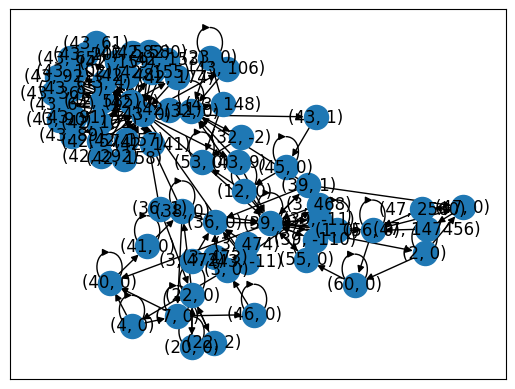

In [6]:
nx.draw_networkx(myslqd_scg)
plt.show()

In [1]:
from queue import Queue

In [2]:
q = Queue(maxsize=0)
q.put({1:[0.1, 1234, 123]})
q.put({2:[0.2, 2234, 223]})
q.put({3:[0.3, 3234, 223]})

In [3]:
print(q.queue)

deque([{1: [0.1, 1234, 123]}, {2: [0.2, 2234, 223]}, {3: [0.3, 3234, 223]}])


In [8]:
q.queue.clear()

In [9]:
print(q.queue)

deque([])


测试多重索引功能

In [39]:
result = {}

df_data = []

result['mindex'] = 0
result['time'] = '2021-09-08 10:00:00'
result['s'] = 1

df_data.append(result)

result= {}
result['mindex'] = 1
result['time'] = '2021-09-08 10:00:01'
result['s'] = 2
df_data.append(result)

result= {}
result['mindex'] = 1
result['time'] = '2021-09-08 10:00:02'
result['s'] = 3
df_data.append(result)


In [40]:
df_data

[{'mindex': 0, 'time': '2021-09-08 10:00:00', 's': 1},
 {'mindex': 1, 'time': '2021-09-08 10:00:01', 's': 2},
 {'mindex': 1, 'time': '2021-09-08 10:00:02', 's': 3}]

In [105]:
df = pd.DataFrame(df_data)

In [106]:
df

,mindex,time,s
0,0,2021-09-08 10:00:00,1
1,1,2021-09-08 10:00:01,2
2,1,2021-09-08 10:00:02,3


In [82]:
df1 = df.set_index(['mindex'])

In [107]:
df1

,time,s
mindex,,
0,2021-09-08 10:00:00,1
1,2021-09-08 10:00:01,2
1,2021-09-08 10:00:02,3


In [110]:
df[['mindex', 's']].sum().sum()

8

In [84]:
df2 = df1.groupby(by='mindex')

In [104]:
def handle_group(row):
    print(row[['mindex', 's']].sum())

df2.apply(handle_group)

KeyError: "['mindex'] not in index"

In [19]:
import pickle

In [51]:
arr = np.load('L:\\hids\\dataSet\\GP_DATA_DIR\\CWE-89-SQL-injection\\training\\acidic_ganguly_5247\\array.npy', allow_pickle=True)

with open('L:\\hids\\dataSet\\GP_DATA_DIR\\CWE-89-SQL-injection\\training\\acidic_ganguly_5247\\df_all.pkl', 'rb') as f:
    df_all =  pickle.load(f)

In [2]:
data = [[1,2,3,4,5,6], [6,5,4,3,2,1]]

In [3]:
data = np.array(data)

In [2]:
df = pd.read_csv('L:\\hids\\dataSet\\CWE-89-SQL-injection_train\\test\\normal\\colossal_sammet_5112.sc',delim_whitespace = True, names = ['Timestamp','UserID', 'PID', 'ProcessName', 'TID', 'syscall', 'Dir', 'Ret', 'Args'])

In [3]:
import visdom

viz = visdom.Visdom()

viz.line(X=[0.],  # x坐标
         Y=[0.],  # y值
        win="line1",  # 窗口id
        name="Adam梯度",  # 线条名称
        update='append',  # 以添加方式加入
        opts={
            'showlegend': True,  # 显示网格
            'xlabel': "x1",  # x轴标签
            'ylabel': "y1",  # y轴标签
        },)

for i in range(10):
    viz.line(X=[i], Y=[i*2],name="Adam梯度", win='line1', update='append')

    viz.line(X=[i], Y=[i**2],name="SGD梯度", win='line1', update='append')

    viz.line(X=[i], Y=[5*i+2],name="GDM梯度", win='line1', update='append')

Setting up a new session...
